# Flatiron School Phase 4 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: ****

Instructor name: **Mark Barbour**

Blog post URL: **[x]**

# INTRODUCTION

### Stakeholder


### Data: Origin & Usage



### Methods Justification & Value to Stakeholder



### Limitations



### Model Evaluation



In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display_html
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime

import warnings
warnings.filterwarnings("ignore")

In [11]:
data = pd.read_csv('data/zillow_data.csv')

In [12]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time', inplace=True)
    return melted

In [13]:
# Changing from wide to long format
df = melt_data(data)

# Making sure each zipcode in the dataset has the full 265 months of data
df['zipcount'] = df['RegionName'].map(df.RegionName.value_counts())
df = df[df.zipcount==265]

# Changing the name of the zipcode column to accurately reflect what it contains.
df['zipcode'] = df['RegionName']
df.drop(['RegionName'], axis=1, inplace=True)

In [14]:
df = df.query("State=='MI'")

In [15]:
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

# Helper functions

In [16]:
def volatility_score(lst):
    
    """
    A relatively simple function that gauges the amount
    of volatility in a dataset. It:
    
    1) uses the magnitude of the slope changes in the dataset 
    (the values of the second derivative)
    
    2) squares them to avoid negative values cancelling out positive
    values, and penalize greater changes at the same time
    
    3) Averages the squared changes
    
    4) Divides the average squared change by the range of the dataset
    and the length of the dataset to normalize it
    """
    
    series = pd.Series(lst)
    changes = series.diff(1).diff(1)
    squared_changes = changes.map(lambda x: x**2)
    mean_squared_change = squared_changes.mean()
    rng = series.max() - series.min()
    return (mean_squared_change/(rng**2)) * len(series)

In [157]:
def ad_pvalue(dataframe):
    """
    Performs an augmented dickey-fuller test on some data,
    and returns the pvalue.
    """
    dftest = adfuller(dataframe)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput['p-value']

def kpss_pvalue(dataframe):
    """
    Performs a Kwiatkowski–Phillips–Schmidt–Shin test on some data,
    and returns the pvalue.
    """
    kpsstest = kpss(dataframe, regression='ct')
    return kpsstest[1]

# General trend of house price data

You can see the effects of the 2008 housing market crash on what was an otherwise ever-increasing series of data points. This crash was an anomaly in the general upward trend of housing prices. I will only keep data after 2012, which is when the housing market slump seemed to be over.

In [17]:
grouped = df.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

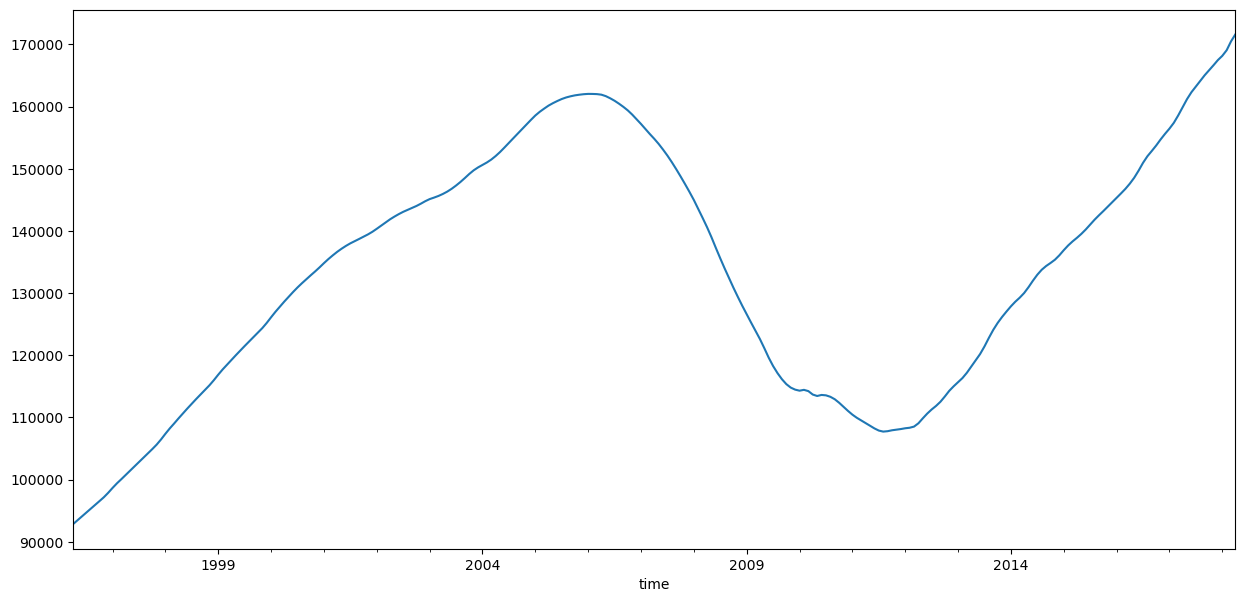

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Data after the housing market crash

As expected, we have removed the anomalous housing market crash and what remains is a normal, linearly trending group of data for housing prices. This is the data that we will use for our models.

In [19]:
# Keeping data during and after 2012
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

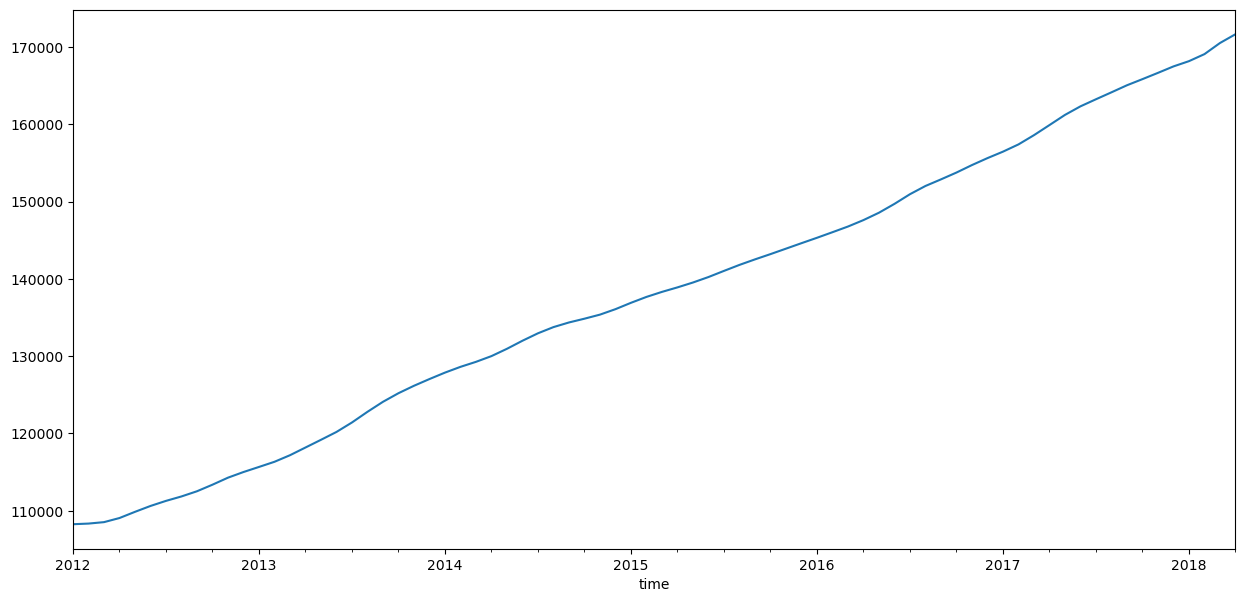

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Number of zipcodes

Our stakeholder wants us to examine all the zipcodes in the dataset. There are 13,684 zipcodes in total, spread out across all 50 states. To find out which zipcodes are the best ones to invest in, we will have to forecast housing prices in each zipcode, which means fitting at least one model to each. ARIMA and SARMIAX do not take categorical exogenous variables, only numerical ones, which excludes the zipcode variable from being included in either type of model.

In [21]:
df.dtypes

RegionID        int64
SizeRank        int64
City           object
State          object
Metro          object
CountyName     object
value         float64
zipcount        int64
zipcode         int64
dtype: object

In [22]:
df.zipcode.nunique()

453

In [23]:
df.State.nunique()

1

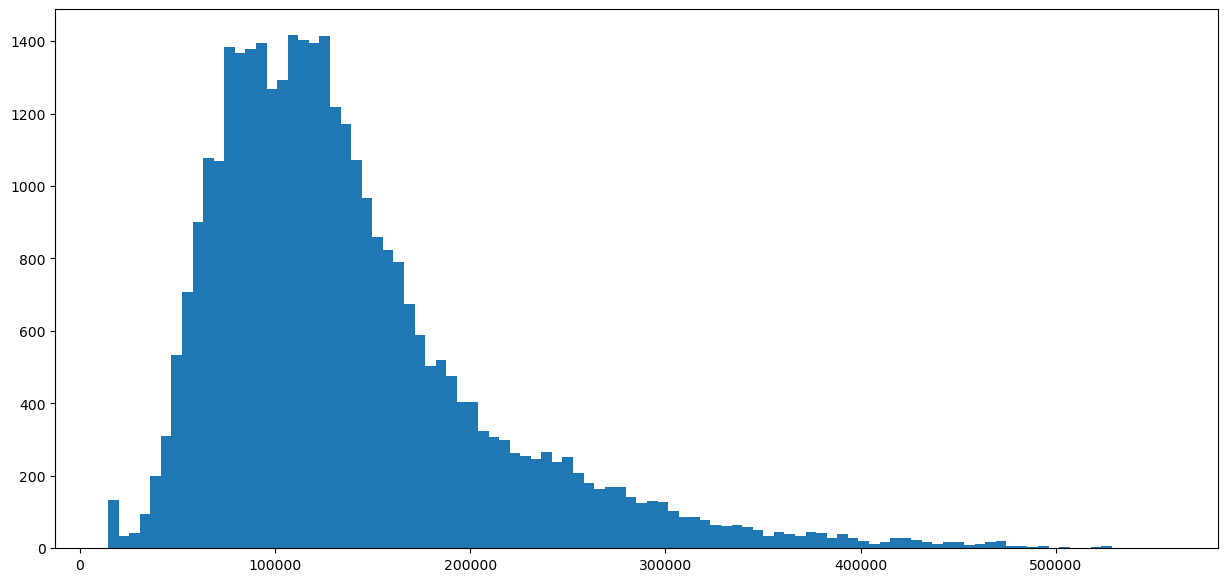

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(ad_2012.value, bins=100);

# Kinds of zipcodes

Although the aggregated dataset shows a clear upwards trend, not all zipcodes follow this pattern. There are zipcodes that follow a very linear upward trajectory, but there are others that follow a more cyclical path. This suggests that there is no one model that will fit well to all the zipcodes.

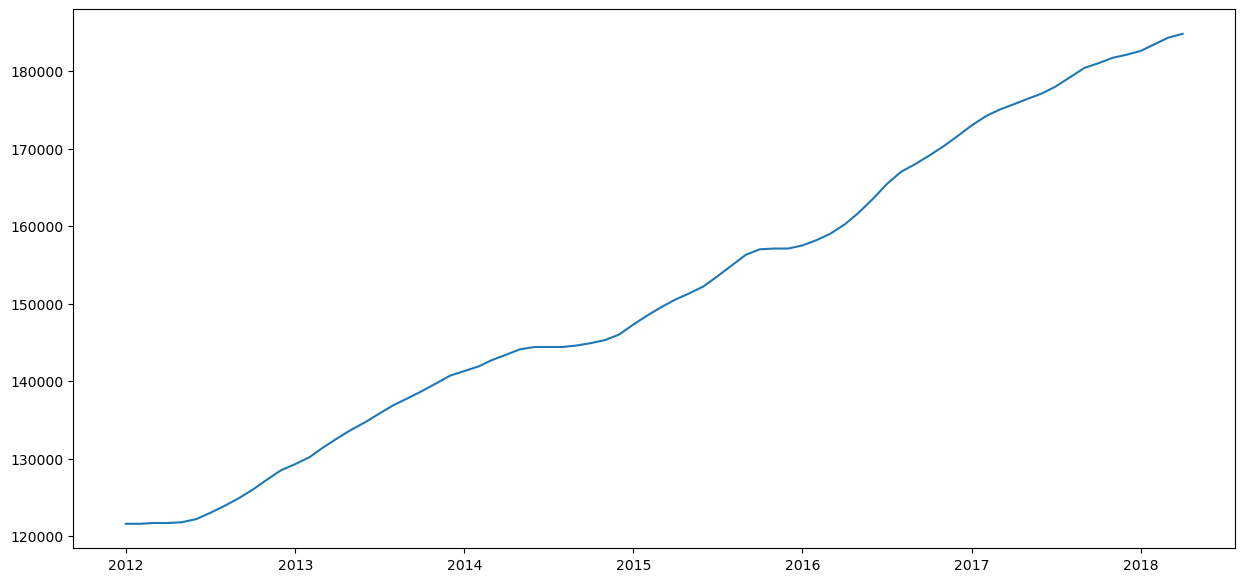

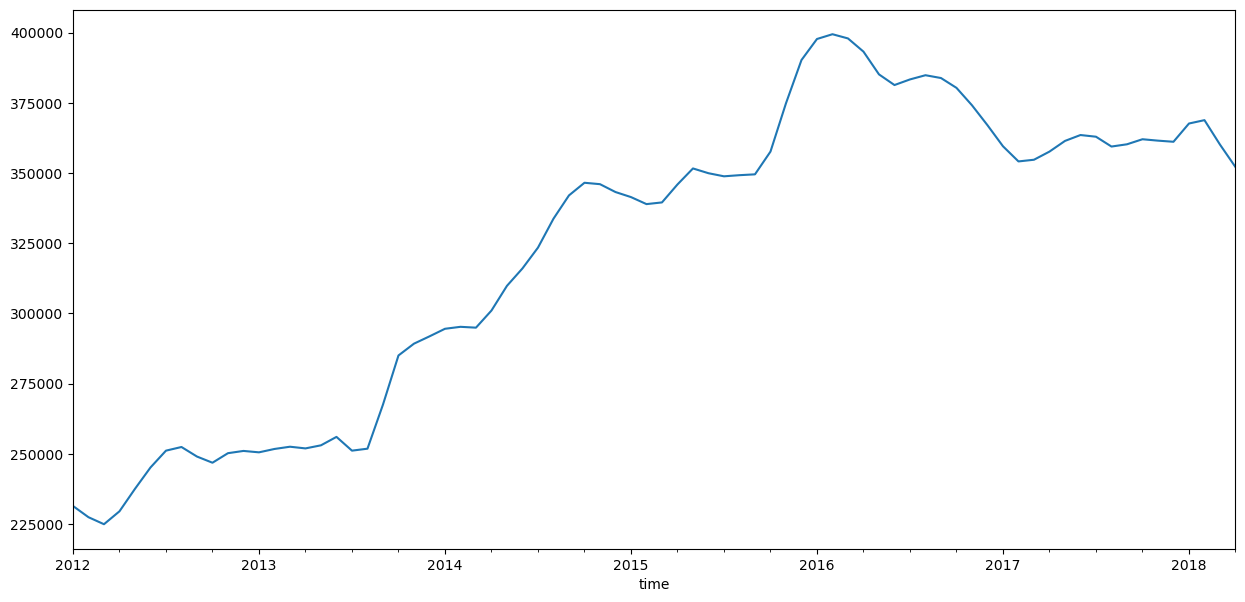

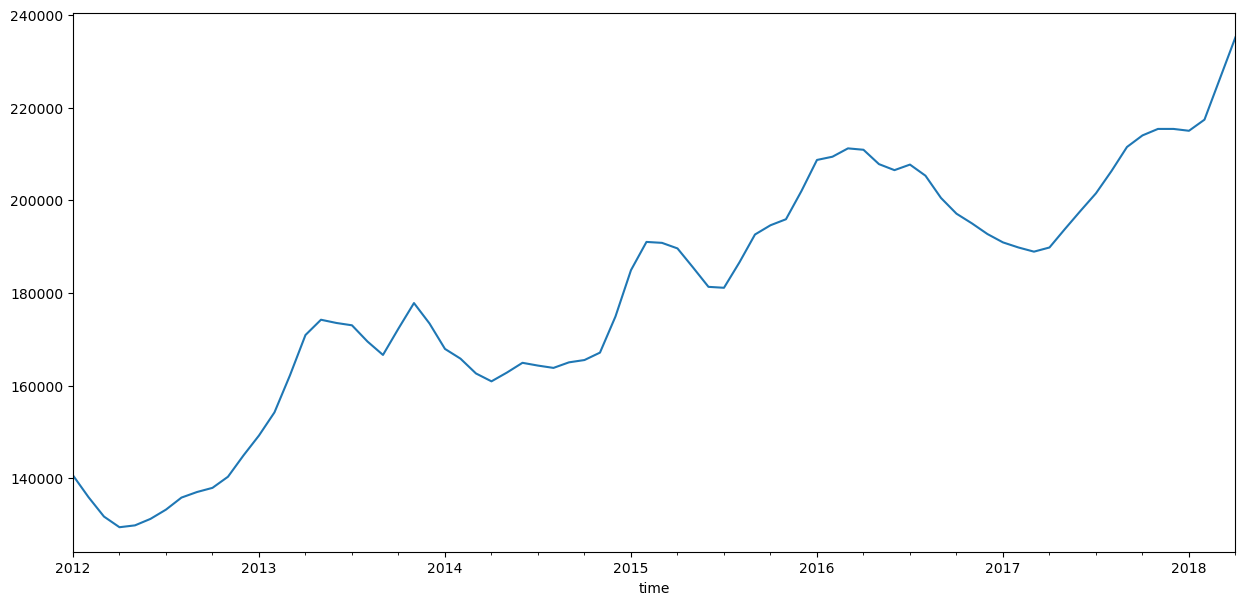

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(ad_2012[ad_2012.zipcode==49428].value)

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==49129].value.plot()

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==49060].value.plot();

# Naive Models

The baseline naive model we will use is a model with all values shifted forward by 1.

A successful model will successfully extract all temporal components from each zipcode's time series, and the accompanying model residuals will be stationary.

In [27]:
st = time.time()

mses = []
ad_pvalues, kpss_pvalues = [], []
residuals_list = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    # After shifting, the first value will be null,
    # so this value is eliminated from the set.
    shifted = zipcode.shift(1)[1:]
    
    # The first value in the original dataset is also
    # eliminated so we can perform the mean squared error.
    mse = mean_squared_error(zipcode[1:], shifted)
    mses.append(mse)
    
    residuals = shifted-zipcode[1:]
    residuals_list.append(residuals)
    
    # Two statistical tests, the adfuller and the kpss test,
    # are performed on the model residuals (errors).
    # Having two separate tests agree on stationarity is better
    # than only using one.
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    # Helpful ticker
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 1.723618984222412 seconds


In [29]:
# Uses the results from the loop to make a dataframe for easy analysis.
naive_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'mse': mses, 
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list})

In [109]:
tests_in_agreement = len(naive_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(naive_model_df)
print("\n")
print(f"{round(tests_in_agreement * 100, 2)}% of all naive models are stationary according to both statistical tests.")
print("\n")



57.62% of all naive models are stationary according to both statistical tests.




In [98]:
naive_model_mse = round(naive_model_df.mse.mean(), 2)
print("\n")
print(f"The mean squared error for all naive models is {f'{naive_model_mse:,}.'}")
print("\n")



The mean squared error for all naive models is 2,213,863.72.




In [101]:
bounds = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
print("\n")
for i in range(len(bounds)-1):
    string = f"{i+3}-figure MSEs: "
    num_mses = len(naive_model_df[(naive_model_df.mse>=bounds[i]) & (naive_model_df.mse<bounds[i+1])])
    print(string + str(num_mses))
print("\n")



3-figure MSEs: 0
4-figure MSEs: 0
5-figure MSEs: 0
6-figure MSEs: 137
7-figure MSEs: 309
8-figure MSEs: 7
9-figure MSEs: 0
10-figure MSEs: 0




In [102]:
naive_model_mse_adj = round(naive_model_df.query("mse<1e7").mse.mean(), 2)
print("\n")
print(f"The mean squared error for all naive models, adjusting for outliers, is {f'{naive_model_mse_adj:,}.'}")
print("\n")



The mean squared error for all naive models, adjusting for outliers, is 1,956,098.06.




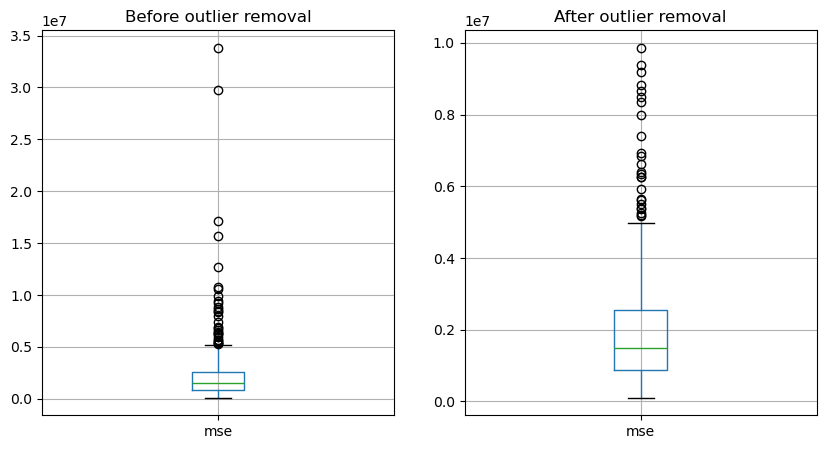

In [110]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

naive_model_df.boxplot(column=['mse'], ax=ax[0])
ax[0].set_title("Before outlier removal")

naive_model_df.query("mse<1e7").boxplot(column=['mse'], ax=ax[1])
ax[1].set_title("After outlier removal");

# Deciding our parameters for the ARIMA model

We are moving onto ARIMA models. ARIMA models have three main parameters:

- p: AR term
– d: difference
- q: MA term

Looking at our autocorrelation and partial autocorrelation plots, it looks like we should at least make one difference on the data. Let's perform the difference and then re-evaluate the partial and autocorrelation plots.

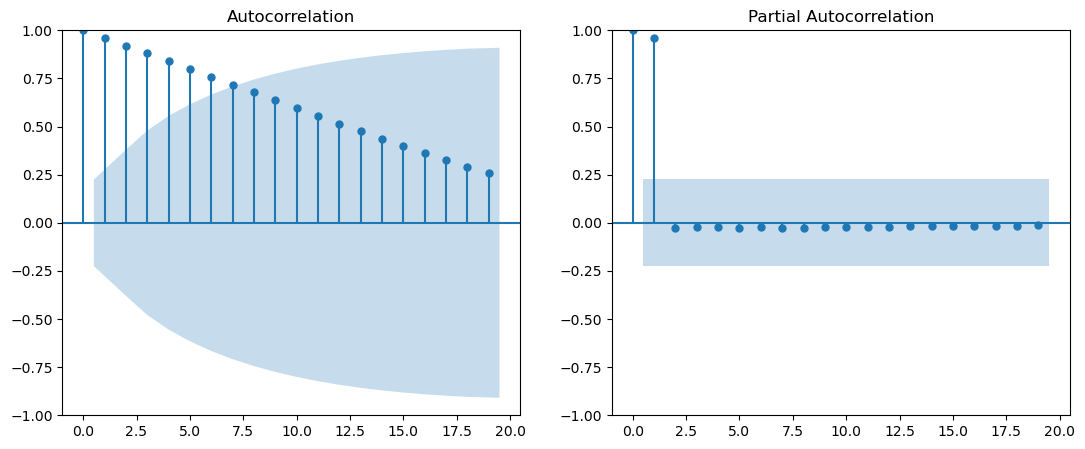

In [120]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

plot_acf(grouped.value, ax=ax[0]);
plot_pacf(grouped.value, ax=ax[1]);

# Differencing the series

After differencing the aggregated series, the number of significant lags went down from 7 to 1. These suggest that our first model should have one AR terms, one MA term, and one difference.

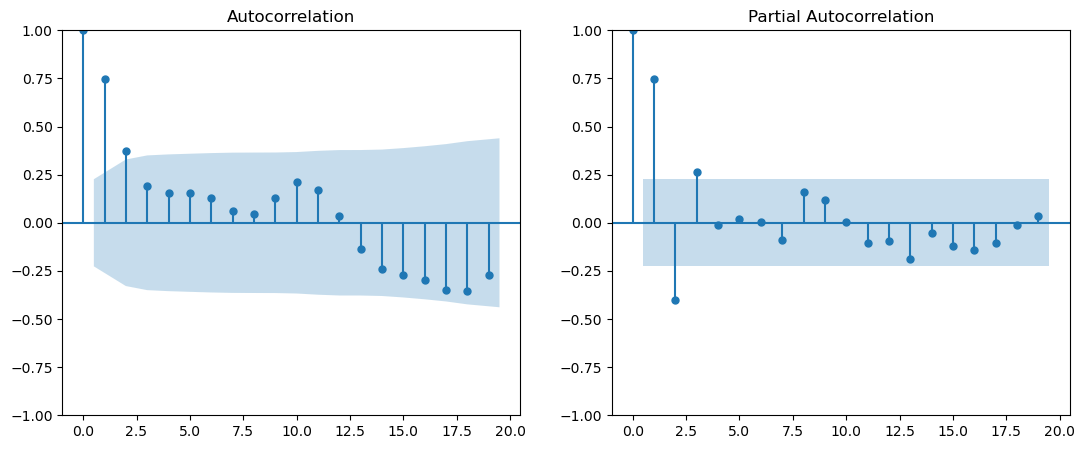

In [121]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

plot_acf(grouped.diff(1).value[1:], ax=ax[0]);
plot_pacf(grouped.diff(1).value[1:], ax=ax[1]);

# Running ARIMA models of order (1,1,1)

Using one AR term, one MA term, and one difference per the PACF and ACF plots above.

In [122]:
st = time.time()

predictions_list = []
forecasts = []
original = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    original.append(zipcode)
    print(f"Zipcode: {zc}")

    # Instantiates, trains, and fits model
    model = ARIMA(zipcode, order=(1, 1, 1)).fit()
            
    # This is the model's predictions for the training data
    predictions = model.predict()
    predictions_list.append(predictions)
    
    # This is the model's forecast for the next three months
    forecast = model.get_forecast(steps=3).predicted_mean
    forecasts.append(forecast)
    
    # Helpful ticker
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 15.936640977859497 seconds


In [123]:
# Uses the results from the loop to make a dataframe for easy analysis.
arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'original': original})

# Refines some existing columns and calculates the model residuals and mse.
arima_model_df['predictions'] = arima_model_df.predictions.map(lambda x: x[1:])
arima_model_df['original'] = arima_model_df.original.map(lambda x: x[1:])
arima_model_df['residuals'] = [arima_model_df.original.iloc[i] - arima_model_df.predictions.iloc[i] for i in range(len(arima_model_df))]
arima_model_df['mse'] = [mean_squared_error(arima_model_df.original.iloc[i], arima_model_df.predictions.iloc[i]) for i in range(len(arima_model_df))]

# Performs two stationarity tests on the model residuals.
arima_model_df['adfuller_pvalue'] = arima_model_df['residuals'].map(ad_pvalue)
arima_model_df['kpss_pvalue'] = arima_model_df['residuals'].map(kpss_pvalue)

In [128]:
arima_tests_in_agreement = len(arima_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(arima_model_df)
print("\n")
print(f"{round(arima_tests_in_agreement * 100, 2)}% of all basic ARIMA models are stationary according to both statistical tests.")
print("\n")



61.15% of all basic ARIMA models are stationary according to both statistical tests.




In [129]:
arima_model_mse = round(arima_model_df.mse.mean(), 2)
print("\n")
print(f"The mean squared error for all basic ARIMA models is {f'{naive_model_mse:,}.'}")
print("\n")



The mean squared error for all basic ARIMA models is 1,328,207.79.




In [130]:
bounds = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
print("\n")
for i in range(len(bounds)-1):
    string = f"{i+3}-figure MSEs: "
    num_mses = len(arima_model_df[(arima_model_df.mse>=bounds[i]) & (arima_model_df.mse<bounds[i+1])])
    print(string + str(num_mses))
print("\n")



3-figure MSEs: 0
4-figure MSEs: 0
5-figure MSEs: 5
6-figure MSEs: 260
7-figure MSEs: 185
8-figure MSEs: 3
9-figure MSEs: 0
10-figure MSEs: 0




In [132]:
arima_model_mse_adj = round(arima_model_df.query("mse<1e7").mse.mean(), 2)
print("\n")
print(f"The mean squared error for all naive models, adjusting for outliers, is {f'{arima_model_mse_adj:,}.'}")
print("\n")



The mean squared error for all naive models, adjusting for outliers, is 1,161,161.62.




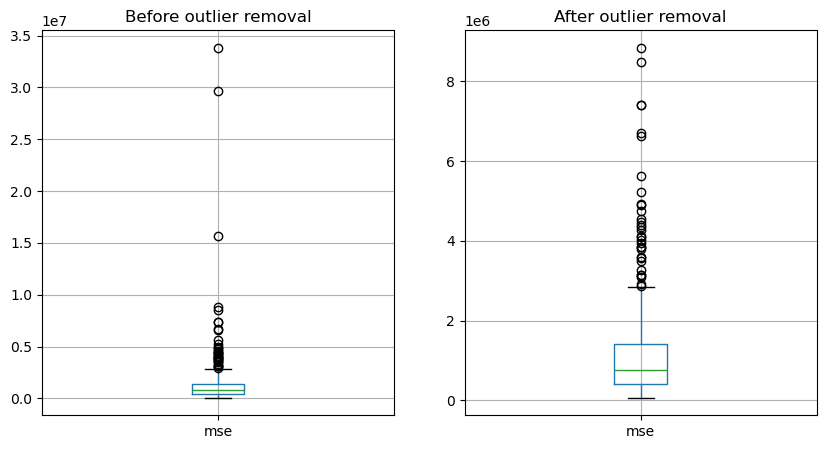

In [133]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

arima_model_df.boxplot(column=['mse'], ax=ax[0])
ax[0].set_title("Before outlier removal")

arima_model_df.query("mse<1e7").boxplot(column=['mse'], ax=ax[1])
ax[1].set_title("After outlier removal");

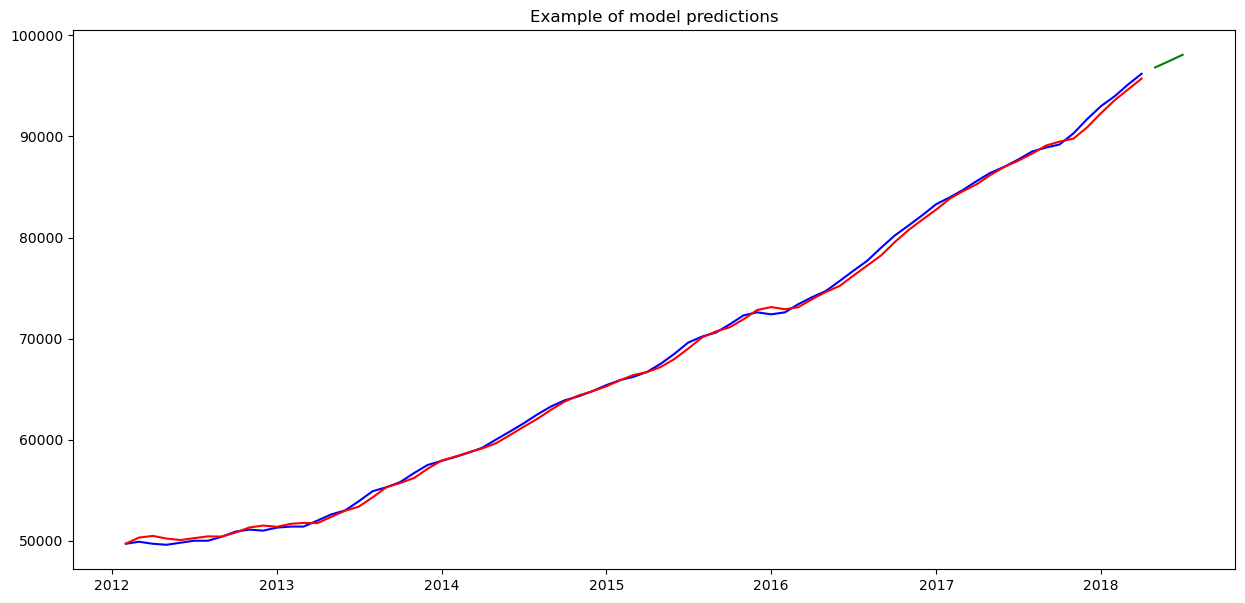

In [137]:
fig, ax = plt.subplots(figsize=(15,7))

row=arima_model_df.iloc[1]
ax.plot(row.original, c='blue', label='original')
ax.plot(row.predictions, c='red', label='predictions')
ax.plot(row.forecast, c='green', label='forecast')
ax.set_title("Example of model predictions");

# Train-test split

The models appear to be in working order. However, we have not implemented a train-test split. We will include all years from 2012 – 2017 for the training data, and everything after will be for the test portion of our dataset.

In [138]:
st = time.time()

predictions_list = []
forecasts = []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    print(f"Zipcode: {zc}")
    
    # Splits data into train and test sets along the 
    # end of 2016.
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    
    trains.append(train[1:])
    tests.append(test)

    # Instantiates, trains, and fits ARIMA model.
    model = ARIMA(train, order=(1, 1, 1)).fit()
            
    # Makes predictions on the training dataset.
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    # Makes 19 predictions, 16 of which will be predictions
    # for test data, and the last 3 go beyond all available
    # data.
    forecast = model.get_forecast(steps=19).predicted_mean
    forecasts.append(forecast)
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 15.18290114402771 seconds


In [139]:
# Uses the results from the loop to make a dataframe for easy analysis.
tts_arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains, 
                               'test': tests})

# Refines some existing columns and calculates the train and test mse.
tts_arima_model_df['train_predictions'] = tts_arima_model_df.predictions.map(lambda x: x[0:60])
tts_arima_model_df['test_predictions'] = tts_arima_model_df.forecast.map(lambda x: x[:16])
tts_arima_model_df['forecast'] = tts_arima_model_df.forecast.map(lambda x: x[16:])
tts_arima_model_df['train_mse'] = [mean_squared_error(tts_arima_model_df.train.iloc[i], tts_arima_model_df.train_predictions.iloc[i]) for i in range(len(tts_arima_model_df))]
tts_arima_model_df['test_mse'] = [mean_squared_error(tts_arima_model_df.test.iloc[i], tts_arima_model_df.test_predictions.iloc[i]) for i in range(len(tts_arima_model_df))]

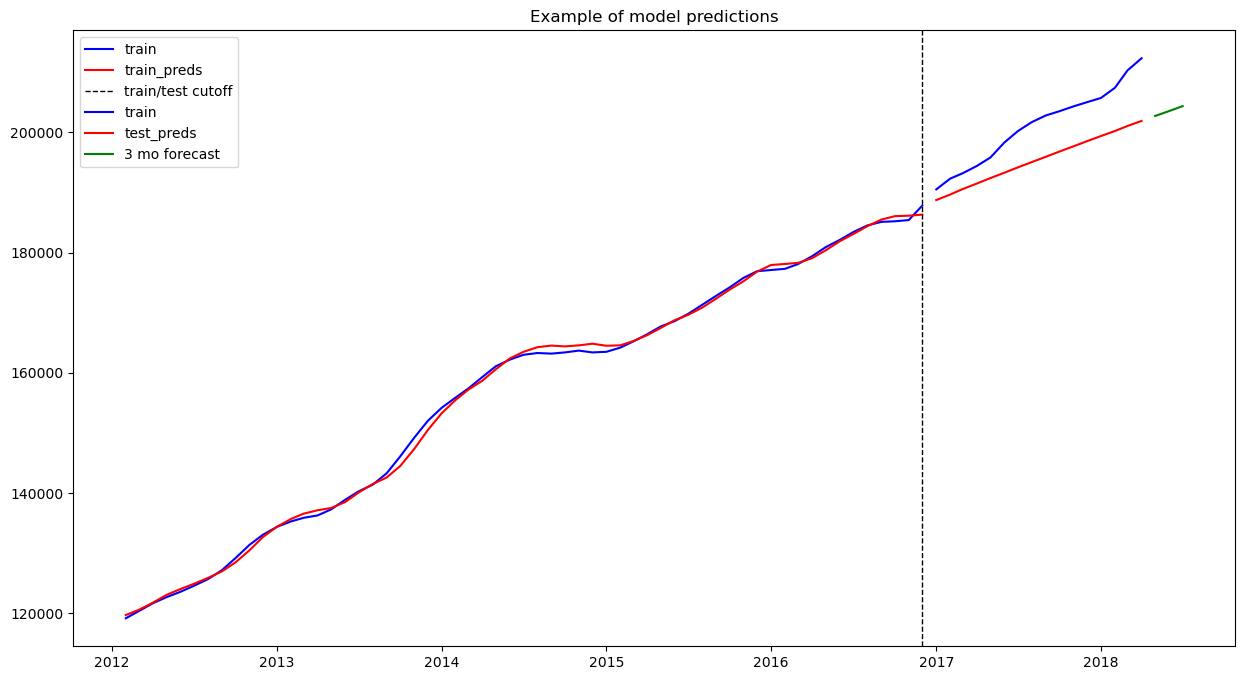

In [160]:
row = tts_arima_model_df.iloc[0]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.train_predictions, c='red', label='train_preds')
ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')
ax.plot(row.test, c='blue', label='train')
ax.plot(row.test_predictions, c='red', label='test_preds')
ax.plot(row.forecast, c='green', label='3 mo forecast')
ax.set_title("Example of model predictions")
ax.legend();

In [149]:
bounds = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
print("\n")
for i in range(len(bounds)-1):
    string = f"{i+3}-figure train MSEs: "
    num_mses = len(tts_arima_model_df[(tts_arima_model_df.train_mse>=bounds[i]) & (tts_arima_model_df.train_mse<bounds[i+1])])
    print(string + str(num_mses))
print("\n\n")


bounds = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
print("\n")
for i in range(len(bounds)-1):
    string = f"{i+3}-figure test MSEs: "
    num_mses = len(tts_arima_model_df[(tts_arima_model_df.test_mse>=bounds[i]) & (tts_arima_model_df.test_mse<bounds[i+1])])
    print(string + str(num_mses))
print("\n")



3-figure train MSEs: 0
4-figure train MSEs: 0
5-figure train MSEs: 11
6-figure train MSEs: 285
7-figure train MSEs: 154
8-figure train MSEs: 3
9-figure train MSEs: 0
10-figure train MSEs: 0





3-figure test MSEs: 0
4-figure test MSEs: 0
5-figure test MSEs: 0
6-figure test MSEs: 14
7-figure test MSEs: 135
8-figure test MSEs: 243
9-figure test MSEs: 61
10-figure test MSEs: 0




In [155]:
tts_arima_model_mse_train = round(tts_arima_model_df.train_mse.mean(), 2)
tts_arima_model_mse_test = round(tts_arima_model_df.test_mse.mean(), 2)
difference = round(tts_arima_model_df.test_mse.mean() / tts_arima_model_df.train_mse.mean(), 2)

print("\n")
print(f"The mean squared error for all basic ARIMA models on the training dataset is {f'{tts_arima_model_mse_train:,}.'}")
print(f"The mean squared error for all basic ARIMA models on the test dataset is {f'{tts_arima_model_mse_test:,}.'}")
print(f"The mean squared error on the training dataset is {difference} times greater than that for the test dataset.")
print("\n")



The mean squared error for all basic ARIMA models on the training dataset is 1,216,349.85.
The mean squared error for all basic ARIMA models on the test dataset is 48,796,055.35.
The mean squared error on the training dataset is 40.12 times greater than that for the test dataset.




# Rolling forecasts

Will a rolling forecast decrease overfitting?

In [156]:
st = time.time()

predictions_list = []
forecasts = []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    # Splits data into train and test sets along the 
    # end of 2016.
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    
    trains.append(train[1:])
    tests.append(test)
    
    # Makes predictions on the training dataset.
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    for x in range(19):
        
        # Instantiates, trains, and fits model.
        model = ARIMA(train, order=(1, 1, 1)).fit()
        
        # Makes a prediction and appends it to the training dataset.
        # The model will be re-trained on this updated dataset
        # in the next loop iteration, before making its next prediction.
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{19} done.")
    
    forecast = train[60:]
    forecasts.append(forecast)
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #19/19 done.
Execution time: 313.1119878292084 seconds


In [165]:
# Uses the results from the loop to make a dataframe for easy analysis.
rolling_arima_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains, 
                               'test': tests})

# Refines some existing columns and calculates the train and test mse.
rolling_arima_df['train_predictions'] = rolling_arima_df.predictions.map(lambda x: x[:59])
rolling_arima_df['test_predictions'] = rolling_arima_df.forecast.map(lambda x: x[:16])
rolling_arima_df['forecast'] = rolling_arima_df.forecast.map(lambda x: x[16:])
rolling_arima_df['train_mse'] = [mean_squared_error(rolling_arima_df.train.iloc[i], rolling_arima_df.train_predictions.iloc[i]) for i in range(len(rolling_arima_df))]
rolling_arima_df['test_mse'] = [mean_squared_error(rolling_arima_df.test.iloc[i], rolling_arima_df.test_predictions.iloc[i]) for i in range(len(rolling_arima_df))]

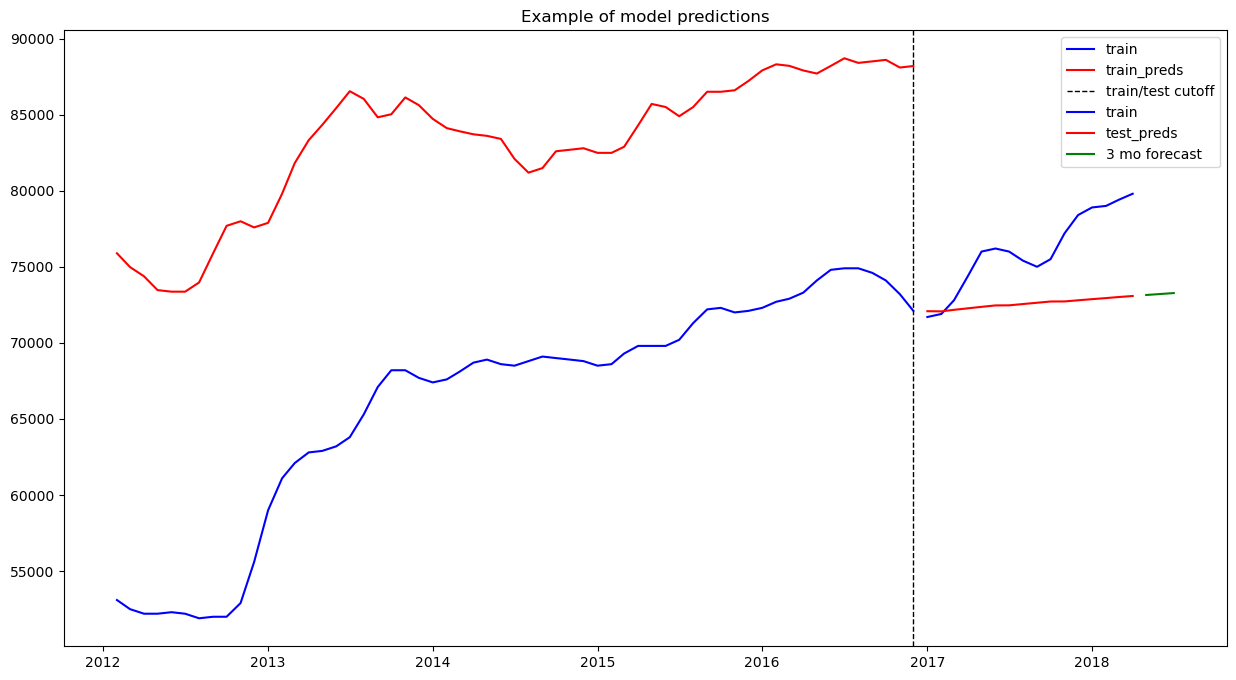

In [166]:
row = rolling_arima_df.iloc[-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.train_predictions, c='red', label='train_preds')
ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')
ax.plot(row.test, c='blue', label='train')
ax.plot(row.test_predictions, c='red', label='test_preds')
ax.plot(row.forecast, c='green', label='3 mo forecast')
ax.set_title("Example of model predictions")
ax.legend();

In [163]:
rolling_arima_df.train_mse.mean()

7890363060.15361

In [164]:
rolling_arima_df.test_mse.mean()

44522108.44289325

In [371]:
rolling_arima_df.test_mse.mean() / tts_arima_model_df.train_mse.mean()

36.603045053429696

In [372]:
len(rolling_arima_df.query("test_mse>100000000"))

54

In [373]:
rolling_arima_df.query("test_mse<100000000").test_mse.mean()

25738863.342910778

# Rolling ARIMA on just last three forecasts

Now that we've established a rolling ARIMA outperforms a standard ARIMA in terms of overfitting and prediction accuracy, we can use ARIMA on all our available train data and just do the rolling model on the last three forecasts.

In [168]:
st = time.time()

predictions_list = []
forecasts = []
trains = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    train = ad_2012[ad_2012.zipcode==zc].value
    
    trains.append(train[1:])
    
    model = ARIMA(train, order=(1, 1, 1)).fit()
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    for x in range(3):
        model = ARIMA(train, order=(1, 1, 1)).fit()
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{3} done.")
    
    forecast = train[-3:]
    forecasts.append(forecast)
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #3/3 done.
Execution time: 63.4533953666687 seconds


In [169]:
rolling_arima_df_2 = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains})

rolling_arima_df_2['train_mse'] = [mean_squared_error(rolling_arima_df.train.iloc[i], rolling_arima_df.predictions.iloc[i]) for i in range(len(rolling_arima_df))]

ValueError: Found input variables with inconsistent numbers of samples: [59, 77]

In [ ]:
row = rolling_arima_df_2.iloc[-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.predictions, c='red', label='train_preds')

ax.plot(row.forecast, c='green', label='3 mo forecast')

ax.legend()

In [ ]:
percentage_increases = []

for zipcode in ad_2012.zipcode.unique():
    zc = ad_2012[ad_2012.zipcode==zipcode].value
    percentage_increase = (zc.iloc[-1] / zc.iloc[0])
    percentage_increases.append(percentage_increase)

increases = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 'percentage_increase': percentage_increases})

# 

In [ ]:
volatilities = pd.DataFrame({'zipcode': ad_2012.zipcode.unique()})
volatilities['volatility'] = volatilities.zipcode.map(lambda x: volatility_score(ad_2012[ad_2012.zipcode==x].value))

In [703]:
volatilities.sort_values(by='volatility')

,zipcode,volatility
118,49428,1.062692
3,48185,1.086344
53,49505,1.137482
81,48080,1.261749
23,49504,1.310345
...,...,...
448,49322,51.082158
443,48897,51.574206
447,49102,73.281053
418,49060,83.390385
